## Setup

### Importing Dependencies

In [1]:
# Data Loading
from datasets import load_dataset
import pandas as pd

# Torch for training models
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR

from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel # For obtaining GPT-2 embeddings

# Mathematical libraries
import numpy as np
import math
import cmath
import random
from scipy import stats
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from sklearn.utils import check_array
from sklearn.cluster import MiniBatchKMeans
import dcor

# Visualization and data saving
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
import umap
import pickle

# Utitlties
import copy
from collections import Counter
from functools import partial

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


### Fixing Random Seeds for Reproducibility

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

### Selecting Project Directory

In [3]:
proj_dir = "QLens/" # Personalize if needed

## Loading and Preparing Dataset

In [4]:
df_file = '5_Core_Books_50k.tsv'
df = pd.read_csv(f"{proj_dir}{df_file}", sep='\t')

In [5]:
# Obtaining statistics of df
unique_titles = df['title:token'].unique()
num_items = len(unique_titles)
print(f"Filtered dataset has {num_items} unique items and {df['user_id:token'].nunique()} users.")

Filtered dataset has 185136 unique items and 42696 users.


### Constructing Dataset Splits

In [6]:
# Mapping book titles to new 0-based ids
title_to_id = pd.Series(np.arange(num_items), index=unique_titles).to_dict()
df['item_new_id'] = df['title:token'].map(title_to_id).astype(np.int64)

In [7]:
# Building per-user histories (list of item ids)
user_hist_series = df.groupby('user_id:token')['item_new_id'].apply(list) # pandas Series

user_histories = user_hist_series.tolist() # List of lists

In [8]:
# Creating data splits
train_set = [hist[:-2] for hist in user_histories]
val_set   = [hist[:-1] for hist in user_histories]
test_set  = [hist for hist in user_histories]

### Dataset Class

In [9]:
class BooksDataset(Dataset):
    def __init__(self, user_histories):
        # user_histories is a list of lists of ints (item ids)
        self.user_histories = user_histories

    def __len__(self):
        return len(self.user_histories)

    def __getitem__(self, idx):
        hist = self.user_histories[idx]

        return torch.tensor(hist, dtype=torch.long)

"""
collate_fn() prepares batches for processing by padding them

Args:
    batch (List of 1D LongTensors): Input batch to pad

Returns:
    padded_batch (LongTensor): Padded batch
"""
def collate_fn(batch, pad_token_id):
    padded = pad_sequence(batch, batch_first=True, padding_value=pad_token_id)

    return padded

## Loading Trained Model

In [10]:
class TransformerModel(nn.Module):
    def __init__(self, init_embeddings_tensor, d_embedding, d_model, dim_feedforward, num_heads, dim_class, dropout_rate=0.1, max_seq_len = 275, pad_token_id=None):
        super().__init__()
        self.pad_token_id = pad_token_id

        # init_embeddings_tensor should be a FloatTensor of shape (num_embeddings, d_embedding)
        assert isinstance(init_embeddings_tensor, torch.Tensor)
        num_embeddings, emb_dim = init_embeddings_tensor.shape
        assert emb_dim == d_embedding

        # Creating the embedding layer initalizede to a copy of the input embeddings
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=d_embedding, padding_idx=self.pad_token_id)
        with torch.no_grad():
            self.embedding.weight.copy_(init_embeddings_tensor)

        # Positional Embedding Layer
        self.max_seq_len = max_seq_len
        self.pos_embedding = nn.Embedding(num_embeddings = max_seq_len, embedding_dim = d_model)
        nn.init.normal_(self.pos_embedding.weight, mean=0.0, std=0.02)

        # Model compression, attention, and MLP layers
        self.compression = nn.Linear(d_embedding, d_model)
        self.attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout_rate, batch_first=True)
        self.w1 = nn.Linear(d_model, dim_feedforward)
        self.attention_dropout = nn.Dropout(dropout_rate)
        self.w2 = nn.Linear(dim_feedforward, d_model)
        self.attention_norm = nn.LayerNorm(d_model)
        self.mlp_norm = nn.LayerNorm(d_model)
        self.w1_dropout = nn.Dropout(dropout_rate)
        self.w2_dropout = nn.Dropout(dropout_rate)

        # Classification layer over all valid items
        self.classification_layer = nn.Linear(d_model, dim_class)

        # Training trackers
        self.past_epochs = 0
        self.train_losses = []

    def forward(self, tokens, return_probs=True):

        x = self.embedding(tokens)  # (batch, seq_len, d_embedding)
        compressed = self.compression(x.float())

        # Positional Embeddings
        batch_len, seq_len = tokens.size()
        pos_ids = torch.arange(seq_len, device = tokens.device).unsqueeze(0).expand(batch_len, seq_len)
        pos_embeds = self.pos_embedding(pos_ids)

        compressed = compressed + pos_embeds

        # Attention layer
        causal_mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool, device=compressed.device), diagonal=1)
        key_padding_mask = (tokens == self.pad_token_id)
        attn_out = self.attention(compressed, compressed, compressed, attn_mask=causal_mask, key_padding_mask=key_padding_mask)[0]
        attn_out = attn_out.masked_fill(key_padding_mask.unsqueeze(-1), 0.0)

        y = compressed + self.attention_dropout(attn_out)
        y = self.attention_norm(y)

        # MLP Layer
        mlp_out = self.w1_dropout(nn.functional.gelu(self.w1(y)))
        mlp_out = self.w2_dropout(self.w2(mlp_out))
        y = y + mlp_out
        y = self.mlp_norm(y)

        # Final Classifcation layer
        final_logits = self.classification_layer(y)  # (batch, seq_len, dim_class)
        if not return_probs:
            return final_logits
        else:
            return nn.functional.softmax(final_logits, dim=-1)

    def train_model(self, train_dataloader, criterion, optimizer, num_epochs, device, proj_dir, scheduler=None):
        """
        Model training loop.

        Args:
            train_dataloader (DataLoader): DataLoader of training BooksDataset.
            criterion (torch.nn.loss): Loss function used to train model.
            optimizer (torch.optim): Training optimizer.
            num_epochs (int): Number of epochs to train for.
            device (torch.device): Device to train model on.
            proj_dir (str): Name of project directory to save checkpoints to.
            scheduler (torch.optim.lr_scheduler._LRScheduler or OneCycleLR, optional): If provided,
                will be used to adjust learning rate. If OneCycleLR, the learning
                rate will be stepped per-batch; otherwise once per epoch.
        """

        print("Starting training loop...")
        steps_per_epoch = len(train_dataloader) if hasattr(train_dataloader, '__len__') else None

        # Helper to determine whether scheduler expects per-batch stepping
        per_batch_scheduler = isinstance(scheduler, OneCycleLR)

        start_epoch = self.past_epochs
        for epoch in range(start_epoch, start_epoch + num_epochs):
            self.train()
            epoch_loss = 0.0

            # Progress bar for epoch
            for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{start_epoch + num_epochs}")):
                batch = batch.to(device)
                assert batch.dim() == 2

                # Preparing inputs and labels
                pad_mask = (batch != self.pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1)          # (B,)

                input_tokens = torch.zeros([batch.shape[0], batch.shape[1] - 1]).to(device)
                label_tokens = torch.zeros([batch.shape[0], batch.shape[1] - 1]).to(device)
                for i in range(batch.shape[0]):
                    input_tokens[i, :] = torch.cat((batch[i, :lengths[i] - 1], batch[i, lengths[i]:]))
                    label_tokens[i, :] = batch[i, 1:]

                input_tokens = input_tokens.to(torch.long)
                label_tokens = label_tokens.to(torch.long)

                # Zeroing the optimizer
                optimizer.zero_grad()

                # Obtaining logits
                logits = self(input_tokens, return_probs=False)
                b, s, v = logits.shape
                logits_flat = logits.reshape(-1, v)
                labels_flat = label_tokens.reshape(-1)

                # Computing loss
                loss = criterion(logits_flat, labels_flat)
                epoch_loss += loss.item()

                # Backpropagation
                loss.backward()
                optimizer.step()

                # Step per-batch scheduler (OneCycleLR MUST be stepped per batch)
                if per_batch_scheduler and (scheduler is not None):
                    scheduler.step()

            average_epoch_loss = epoch_loss / max(1, len(train_dataloader))
            self.train_losses.append(average_epoch_loss)

            # If scheduler is not a per-batch one, stepping it once per epoch
            if scheduler is not None and (not per_batch_scheduler):
                try:
                    scheduler.step()
                except Exception:
                    # Some schedulers (e.g., ReduceLROnPlateau) require a metric; skip here
                    pass

            # Obtaining current LR to print
            if scheduler is not None and hasattr(scheduler, "get_last_lr"):
                current_lr = float(scheduler.get_last_lr()[0])
            else:
                current_lr = float(optimizer.param_groups[0]['lr'])

            # Formating training tracker message
            msg = f"Epoch [{epoch+1}/{start_epoch + num_epochs}], Average Loss: {average_epoch_loss:.4f}, Learning Rate: {current_lr:.6g}"

            # Intermediate evaluation on train set to get NDCG@10 and MRR metrics
            eval_results = self.eval_model(train_dataloader, criterion, device)
            ndcg10 = eval_results.get("NDCG@10", float("nan"))
            mrr = eval_results.get("MRR@10", float("nan"))
            msg += f", NDCG@10: {ndcg10:.4f}, MRR: {mrr:.4f}"

            print(msg)
            print('---\n')

        # Updating number of epochs that the model has been trained for
        self.past_epochs += num_epochs

        # Updating the positional embedding weight for sequence lengths longer than that in training
        with torch.no_grad():
            self.pos_embedding.weight[self.max_seq_len - 2] = self.pos_embedding.weight[self.max_seq_len - 3]
            self.pos_embedding.weight[self.max_seq_len - 1] = self.pos_embedding.weight[self.max_seq_len - 3]

        # Saving Checkpoint (include scheduler state if present)
        checkpoint = {
            'epoch': self.past_epochs,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': average_epoch_loss,
        }
        if scheduler is not None:
            try:
                checkpoint['scheduler_state_dict'] = scheduler.state_dict()
            except Exception:
                pass

        torch.save(checkpoint, proj_dir + f'model_checkpoint_{self.past_epochs}_epochs.pth')
        print(f"Checkpoint for Epoch {self.past_epochs} saved")

        # Visualzing loss vs epochs
        plt.figure()
        plt.plot(np.array(range(1, self.past_epochs + 1)), np.array(self.train_losses), "-o")
        plt.grid(True)
        plt.xlabel("Epoch Number")
        plt.ylabel("Loss")
        plt.title("Loss vs Epoch Number")
        plt.savefig(proj_dir + "model_training_loss.png")
        plt.show()


    def eval_model(self, test_dataloader, criterion, device, k = 10):
        """
        Evaluates model using the last item per user on the following criteria:
          - average loss
          - Normalized Discounted Cumulative Gain at k (NDCG@k)
          - Mean Reciprocal Rank at k (MRR@k)

        Args:
            test_dataloader (DataLoader): Contains evaluation set batches.
            criterion (torch.nn.loss): Loss function to compute evaluation loss
            device (torch.device): Device to run evaluation on.
            k (int, optional): k value to compute NDCG@k for, defaults to 10.

        Returns:
            (dict): Contains average evaluation loss, NDCG@k, and MRR@k.
        """

        self.eval()

        val_loss = 0.0
        ndcg_total = 0.0
        rr_total = 0.0
        total_valid = 0  # Number of non-padded last items used in evaluation

        with torch.no_grad():
            for batch in tqdm(test_dataloader, desc="Model Evaluation"):
                batch = batch.to(device)  # (batch, seq_len)

                # Preparing inputs and labels
                pad_mask = (batch != self.pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1)          # (B,)

                input_tokens = torch.zeros([batch.shape[0], batch.shape[1] - 1]).to(device)
                label_tokens = torch.zeros(batch.shape[0]).to(device)
                for i in range(batch.shape[0]):
                    input_tokens[i, :] = torch.cat((batch[i, :lengths[i] - 1], batch[i, lengths[i]:]))
                    label_tokens[i] = batch[i, lengths[i] - 1]

                input_tokens = input_tokens.to(torch.long)
                label_tokens = label_tokens.to(torch.long)

                logits = self(input_tokens, return_probs=False)  # (batch, seq_len-1, vocab_size)

                final_logits = torch.zeros([logits.shape[0], 1, logits.shape[2]]).to(device)
                for i in range(logits.shape[0]):
                    final_logits[i, :, :] = logits[i, lengths[i] - 2, :]

                final_logits = final_logits.squeeze(1)

                # Loss is only calculated on positions not containing the pad token
                try:
                    val_loss += criterion(final_logits, label_tokens).item()
                except Exception as e:
                    # Rare shape mismatch fallback: force shape
                    val_loss += criterion(final_logits, label_tokens.view(-1)).item()

                # Ranking for NDCG & MRR
                # Skipping ranking if pad token is seen in the labels
                valid_mask = (label_tokens != self.pad_token_id)  # shape (batch,)
                if valid_mask.sum().item() == 0:
                    continue

                # Computing top-k indices
                topk_vals, topk_idx = torch.topk(final_logits, k=k, dim=-1)  # (batch, k)

                # Iterating over all valid examples
                labels = label_tokens[valid_mask]
                topk_rows = topk_idx[valid_mask]  # shape (num_valid, k)
                num_valid = labels.size(0)

                for i in range(num_valid):
                    true_item = int(labels[i].item())
                    topk_row = topk_rows[i]

                    # Returns index of match (if present) between logits for i-th user and the true item
                    matches = (topk_row == true_item).nonzero(as_tuple=False)

                    if matches.numel() > 0:
                        rank_index = int(matches[0].item())  # Zero-based indexing is used within top-k
                        dcg = 1.0 / math.log2(rank_index + 2)  # 1-based rank is used in NDCG and MRR
                        rr = 1.0 / (rank_index + 1)
                    else:
                        dcg = 0.0
                        rr = 0.0

                    ndcg_total += dcg
                    rr_total += rr

                total_valid += num_valid

        # Computing averaged evaluation metrics
        avg_val_loss = val_loss / max(1, len(test_dataloader))
        avg_ndcg_at_k = ndcg_total / max(1, total_valid) if total_valid > 0 else 0.0
        avg_mrr_at_k = rr_total / max(1, total_valid) if total_valid > 0 else 0.0

        print(f"\nEvaluation Loss: {avg_val_loss:.4f}, NDCG@{k}: {avg_ndcg_at_k:.4f}, MRR@{k}: {avg_mrr_at_k:.4f}")

        return {
            "avg_val_loss": avg_val_loss,
            f"NDCG@{k}": avg_ndcg_at_k,
            f"MRR@{k}": avg_mrr_at_k
        }

In [11]:
# Selecting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_embeddings = torch.load(os.path.join(proj_dir, 'base_embeddings.pt'))  # shape (num_items+1, d_embedding)
init_embeddings = base_embeddings.float()

num_items = base_embeddings.shape[0] - 1  # Excluding pad row for classes
pad_idx = num_items

# Hyperparamters
d_embedding = base_embeddings.shape[1]
d_model = 128
num_heads = 4
d_ff = 512
batch_size = 8
num_epochs = 15
MAX_USER_INTER = 200

# Datasets
train_dataset = BooksDataset(train_set)
val_dataset  = BooksDataset(val_set)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=partial(collate_fn, pad_token_id=pad_idx))
val_dataloader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False, collate_fn=partial(collate_fn, pad_token_id=pad_idx))

model = TransformerModel(init_embeddings_tensor=init_embeddings,
                         d_embedding=d_embedding,
                         d_model=d_model,
                         dim_feedforward=d_ff,
                         num_heads=num_heads,
                         dim_class=num_items,  # number of real items
                         dropout_rate=0.1,
                         max_seq_len = MAX_USER_INTER,
                         pad_token_id=pad_idx)
    
model.to(device)

TransformerModel(
  (embedding): Embedding(185137, 768, padding_idx=185136)
  (pos_embedding): Embedding(200, 128)
  (compression): Linear(in_features=768, out_features=128, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (w1): Linear(in_features=128, out_features=512, bias=True)
  (attention_dropout): Dropout(p=0.1, inplace=False)
  (w2): Linear(in_features=512, out_features=128, bias=True)
  (attention_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (mlp_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (w1_dropout): Dropout(p=0.1, inplace=False)
  (w2_dropout): Dropout(p=0.1, inplace=False)
  (classification_layer): Linear(in_features=128, out_features=185136, bias=True)
)

In [12]:
# Loading Checkpoint
checkpoint_file = "model_checkpoint_20_epochs.pth"
checkpoint = torch.load(os.path.join(proj_dir, checkpoint_file))

# Loading State Dict
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## Training Tuned Lenses

### Defining Classes and Loss Function

In [13]:
class EmbeddingModel(nn.Module):
# A component of the original Transformer consisting of only its embedding and compression layers
  def __init__(self, embedding, pos_embedding, compression):
    super(EmbeddingModel, self).__init__()

    # Initializing Layers
    self.embedding = embedding
    self.compression = compression

    # Positional Embedding Layer
    self.pos_embedding = pos_embedding

    # Freezing embedding_model parameters
    for param in self.parameters():
      param.requires_grad = False


  def forward(self, tokens):
    """
    Forward pass through embedding model

    Args:
        tokens (torch.Tensor): Contains input title IDs

    Returns:
        final_embeds (torch.Tensor): Contains final compressed embeddigs
    """

    # Embedding layer
    embeds = self.embedding(tokens)

    # Compression layer
    compressed_embeddings = self.compression(embeds.float())

    # Positional Embeddings
    batch_len, seq_len = tokens.size()
    pos_ids = torch.arange(seq_len, device = tokens.device).unsqueeze(0).expand(batch_len, seq_len)
    pos_embeds = self.pos_embedding(pos_ids)

    # Combining Embeddings
    final_embeds = compressed_embeddings + pos_embeds

    return final_embeds

class AttentionModel(nn.Module):
# A component of the original Transformer consisting of only its embedding, compression, and attention layers
  def __init__(self, embedding, pos_embedding, compression, attention, pad_token_id = None):
    super(AttentionModel, self).__init__()

    # Initializing Layers
    self.embedding = embedding
    self.compression = compression
    self.pos_embedding = pos_embedding
    self.attention = attention

    # Setting pad token
    self.pad_token_id = pad_token_id

    # Freezing model parameters
    for param in self.parameters():
      param.requires_grad = False


  def forward(self, tokens):
    """
    Forward pass through attention model

    Args:
        tokens (torch.Tensor): Contains input title IDs

    Returns:
        res_stream (torch.Tensor): Residual stream state after the attention layer
    """

    # Embedding
    embeds = self.embedding(tokens)

    # Compression
    compressed_embeddings = self.compression(embeds)

    # Positional Embeddings
    batch_len, seq_len = tokens.size()
    pos_ids = torch.arange(seq_len, device = tokens.device).unsqueeze(0).expand(batch_len, seq_len)
    pos_embeds = self.pos_embedding(pos_ids)

    # Combining Embeddings
    final_embeds = compressed_embeddings + pos_embeds

    # Attention
    seq_len = final_embeds.size(1)
    causal_mask = torch.triu(
                                torch.ones(seq_len, seq_len, device=final_embeds.device, dtype=torch.bool),
                                diagonal=1
                            )
    key_padding_mask = (tokens == self.pad_token_id)
    attention_output = self.attention(final_embeds, final_embeds, final_embeds, attn_mask = causal_mask, key_padding_mask = key_padding_mask)[0]

    # Residual Addition
    res_stream = final_embeds + attention_output

    return res_stream

In [14]:
class TunedLens(nn.Module):
    def __init__(self, d_model, last_norm, unembedding_layer, name, bias_only = True):
        super(TunedLens, self).__init__()
        self.bias = nn.Parameter(torch.zeros(d_model))  # shape (d_model,)
        self.layer_norm = last_norm
        self.unembedding = unembedding_layer
        self.name = name

        self.bias_only = bias_only
        # If not a bias only, a learnable weight matrix is also needed
        if not bias_only:
            self.weight_mat = nn.Parameter(torch.zeros(d_model, d_model))

        # freezing layer_norm and unembedding
        for param in self.layer_norm.parameters():
            param.requires_grad = False
        for param in self.unembedding.parameters():
            param.requires_grad = False

    def forward(self, x):
        """
        x: (B, S, d_model)
        adds bias and returns logits: (B, S, V)
        broadcasting of bias over batch and seq dims works via PyTorch broadcasting
        """

        if self.bias_only:
            z = x + self.bias  # broadcasts over last dim
        else:
            z = (x @ self.weight_mat) + self.bias

        z = self.layer_norm(z)
        logits = self.unembedding(z)  # (B, S, vocab_size)

        return logits

    def train_model(self,
                    train_dataloader,
                    criterion,
                    optimizer,
                    num_epochs,
                    device,
                    proj_dir,
                    sub_model,
                    final_model,
                    pad_token_id,
                    scheduler=None):
        """
        Trains the TunedLens.

        - train_dataloader yields batches of token ids -> shape (B, S)
        - sub_model and final_model are passed in and used in eval mode under no_grad()
        - scheduler may be per-batch (e.g., OneCycleLR) or per-epoch; this function
          automatically handles both. It prints the LR after each epoch.
        """
        self.to(device)
        train_losses = []

        # detect per-batch scheduler (OneCycleLR or _get_lr_called_within_step)
        per_batch_scheduler = scheduler is not None and hasattr(scheduler, "step") and getattr(scheduler, "_step_count", None) is not None and isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR)

        # ensure teacher models are on device and in eval
        sub_model.to(device)
        final_model.to(device)
        sub_model.eval()
        final_model.eval()

        print("Starting TunedLens training loop...")

        for epoch in range(1, num_epochs + 1):
            self.train()
            epoch_loss = 0.0
            n_batches = 0

            for batch_tokens in tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
                # batch_tokens: LongTensor (B, S) on CPU or pinned memory; move to device
                batch_tokens = batch_tokens.to(device)

                # Preparing inputs and labels
                pad_mask = (batch_tokens != pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1) # (B,) representing valid sequence lengths

                # All but last token of each sequence is inputted into models
                input_tokens = torch.zeros([batch_tokens.shape[0], batch_tokens.shape[1] - 1]).to(device)
                for i in range(batch_tokens.shape[0]):
                    input_tokens[i, :] = torch.cat((batch_tokens[i, :lengths[i] - 1], batch_tokens[i, lengths[i]:]))

                input_tokens = input_tokens.to(torch.long) # Ensuring d-type alignment

                # compute mask of non-pad tokens (True = valid)
                loss_pad_mask = (input_tokens != pad_token_id)  # (B, S)

                # compute teacher signals in no_grad
                with torch.no_grad():
                    residual = sub_model(input_tokens) # shape: (B, S, d_model)
                    final_logits = final_model(input_tokens, return_probs=False) # shape: (B, S, vocab)

                # forward lens (student)
                student_logits = self(residual)  # (B, S, vocab)

                # compute masked KL loss
                loss = criterion(final_logits.float(), student_logits, pad_mask=loss_pad_mask)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # if scheduler is per-batch (e.g., OneCycleLR) step every batch
                if scheduler is not None and per_batch_scheduler:
                    scheduler.step()

                epoch_loss += loss.item()
                n_batches += 1

            avg_epoch_loss = epoch_loss / max(1, n_batches)
            train_losses.append(avg_epoch_loss)

            # step epoch-based schedulers here
            if scheduler is not None and not per_batch_scheduler:
                try:
                    scheduler.step()
                except Exception:
                    # Some schedulers require a metric; we do not call those automatically
                    pass

            # print learning rate
            if scheduler is not None and hasattr(scheduler, "get_last_lr"):
                current_lr = float(scheduler.get_last_lr()[0])
            else:
                current_lr = float(optimizer.param_groups[0]['lr'])

            print(f"Epoch [{epoch}/{num_epochs}]  Avg Loss: {avg_epoch_loss:.6f}  LR: {current_lr:.6g}")

            # optional: small quick eval on train subset or val set can be triggered here

        # Save checkpoint
        checkpoint = {
            'epoch': num_epochs,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss,
        }
        if scheduler is not None:
            try:
                checkpoint['scheduler_state_dict'] = scheduler.state_dict()
            except Exception:
                pass

        torch.save(checkpoint, proj_dir + self.name + '_lens_checkpoint.pth')
        print(f"Checkpoint for Epoch {num_epochs} saved to {proj_dir + self.name + '_lens_checkpoint.pth'}")

        # Plot loss curve
        plt.figure()
        plt.plot(np.arange(1, num_epochs + 1), np.array(train_losses), "-o")
        plt.grid(True)
        plt.xlabel("Epoch Number")
        plt.ylabel("Loss")
        plt.title(f"{self.name} Lens Loss")
        plt.savefig(proj_dir + self.name + "_lens_training_loss.png")
        plt.show()

        return train_losses

    def evaluate_model(self, test_dataloader, criterion, device, sub_model=None, final_model=None, pad_token_id=None):
        """
        Evaluate the TunedLens on batched test data.

        Returns avg loss and accuracy (agreement with teacher's top prediction).
        """
        self.to(device)
        self.eval()
        if sub_model is not None:
            sub_model.to(device)
            sub_model.eval()
        if final_model is not None:
            final_model.to(device)
            final_model.eval()

        total_loss = 0.0
        total_valid = 0
        total_matches = 0

        with torch.no_grad():
            for batch_tokens in tqdm(test_dataloader, desc=f"Eval {self.name} lens"):
                batch_tokens = batch_tokens.to(device)  # (B, S)

                # Preparing inputs and labels
                pad_mask = (batch_tokens != pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1) # (B,) representing valid sequence lengths

                # All but last token of each sequence is inputted into models
                input_tokens = torch.zeros([batch_tokens.shape[0], batch_tokens.shape[1] - 1]).to(device)
                for i in range(batch_tokens.shape[0]):
                    input_tokens[i, :] = torch.cat((batch_tokens[i, :lengths[i] - 1], batch_tokens[i, lengths[i]:]))

                input_tokens = input_tokens.to(torch.long) # Ensuring d-type alignment

                loss_pad_mask = (input_tokens != pad_token_id)

                residual = sub_model(input_tokens) # (B, S, d_model)
                teacher_logits = final_model(input_tokens, return_probs=False) # (B, S, V)
                student_logits = self(residual) # (B, S, V)

                # compute loss
                batch_loss = criterion(teacher_logits.float(), student_logits, pad_mask=loss_pad_mask)
                total_loss += batch_loss.item() * batch_tokens.size(0)  # weight by batch-size for averaging

                # Teacher logits for last valid position
                teacher_last = torch.zeros([teacher_logits.shape[0], 1, teacher_logits.shape[2]]).to(device)
                for i in range(teacher_logits.shape[0]):
                    teacher_last[i, :, :] = teacher_logits[i, lengths[i] - 2, :]
                teacher_last = teacher_last.squeeze(1)

                # Student logits for last valid position
                student_last = torch.zeros([student_logits.shape[0], 1, student_logits.shape[2]]).to(device)
                for i in range(student_logits.shape[0]):
                    student_last[i, :, :] = student_logits[i, lengths[i] - 2, :]
                student_last = student_last.squeeze(1)

                # Computing accuracy of top-1 on last position against teacher's top-1
                teacher_last_tok = teacher_last.argmax(dim=-1) # (B,)
                student_last_tok = student_last.argmax(dim=-1) # (B,)

                total_matches += (teacher_last_tok == student_last_tok).sum().item()
                total_valid += batch_tokens.size(0)

        avg_loss = total_loss / max(1, total_valid)
        accuracy = total_matches / max(1, total_valid)

        print(f"\nEval {self.name} Lens - Avg loss: {avg_loss:.6f}, Accuracy vs teacher (last pos): {accuracy:.4f}")
        return {"avg_val_loss": avg_loss, "accuracy": accuracy}

In [15]:
"""
kl_loss() computes the Kullback-Leibler (KL) divergence loss between
two sets of logits in accordance with the original Tuned Lens paper.

Args:
    base_logits (torch.Tensor): The logits from the base Transformer.
    lens_logits (torch.Tensor): The logits from the Tuned Lens model.

Returns:
    torch.Tensor: The mean KL divergence loss over the batch.
"""
def kl_loss_teacher_student(teacher_logits, student_logits, pad_mask=None):
    """
    Mask-aware KL divergence averaged over valid tokens.
    teacher_logits, student_logits: (B, S, V)
    pad_mask: (B, S) boolean where True = valid token; if None, all tokens valid.
    Returns scalar: mean KL over valid tokens.
    """
    # compute log-probabilities
    log_p = nn.functional.log_softmax(teacher_logits, dim=-1)   # log P (teacher)
    log_q = nn.functional.log_softmax(student_logits, dim=-1)   # log Q (student)
    p = torch.exp(log_p)  # P

    # per-token KL: sum over vocab dimension -> shape (B, S)
    per_token_kl = torch.sum(p * (log_p - log_q), dim=-1)

    if pad_mask is None:
        return per_token_kl.mean()
    else:
        # mask: True where valid
        mask = pad_mask.to(per_token_kl.device).float()
        total_valid = mask.sum()
        if total_valid.item() == 0:
            # no valid tokens: avoid divide-by-zero
            return torch.tensor(0.0, device=per_token_kl.device, requires_grad=True)
        masked_sum = (per_token_kl * mask).sum()
        return masked_sum / total_valid


### Preparing the Embedding Lens

In [17]:
# Hyperparameters
batch_size = 1
num_epochs = 10

# Embedding model
embedding_model = EmbeddingModel(model.embedding, model.pos_embedding, model.compression).to(device)

# Dataset + DataLoader that returns batches of token ids
embedding_train_ds = BooksDataset(val_set)
embedding_test_ds  = BooksDataset(test_set)

embedding_train_loader = DataLoader(embedding_train_ds, batch_size=batch_size, shuffle=True,
                          collate_fn=partial(collate_fn, pad_token_id=pad_idx),
                          num_workers=2, pin_memory=True)

embedding_test_loader = DataLoader(embedding_test_ds, batch_size=batch_size, shuffle=False,
                         collate_fn=partial(collate_fn, pad_token_id=pad_idx),
                         num_workers=2, pin_memory=True)

# instantiate embedding lens
embedding_lens = TunedLens(d_model=d_model,
                           last_norm=model.mlp_norm,
                           unembedding_layer=model.classification_layer,
                           name='embedding',
                           bias_only = False).to(device)

# optimizer & scheduler
embedding_optimizer = optim.Adam(embedding_lens.parameters(), lr=1e-3)

# OneCycleLR (per-batch based LR)
embedding_scheduler = OneCycleLR(embedding_optimizer,
                       max_lr=1e-2,
                       steps_per_epoch=len(embedding_train_loader),
                       epochs=num_epochs,
                       pct_start=0.3)

Starting TunedLens training loop...


Epoch 1/10: 100%|██████████| 42696/42696 [04:20<00:00, 163.71it/s]


Epoch [1/10]  Avg Loss: 2.766923  LR: 0.00280003


Epoch 2/10: 100%|██████████| 42696/42696 [04:17<00:00, 165.50it/s]


Epoch [2/10]  Avg Loss: 2.461417  LR: 0.00760007


Epoch 3/10: 100%|██████████| 42696/42696 [04:19<00:00, 164.41it/s]


Epoch [3/10]  Avg Loss: 2.412615  LR: 0.01


Epoch 4/10: 100%|██████████| 42696/42696 [04:19<00:00, 164.69it/s]


Epoch [4/10]  Avg Loss: 2.376410  LR: 0.00950482


Epoch 5/10: 100%|██████████| 42696/42696 [04:18<00:00, 164.93it/s]


Epoch [5/10]  Avg Loss: 2.353541  LR: 0.00811742


Epoch 6/10: 100%|██████████| 42696/42696 [04:19<00:00, 164.66it/s]


Epoch [6/10]  Avg Loss: 2.335795  LR: 0.00611257


Epoch 7/10: 100%|██████████| 42696/42696 [04:19<00:00, 164.70it/s]


Epoch [7/10]  Avg Loss: 2.320025  LR: 0.00388737


Epoch 8/10: 100%|██████████| 42696/42696 [04:19<00:00, 164.66it/s]


Epoch [8/10]  Avg Loss: 2.307193  LR: 0.00188254


Epoch 9/10: 100%|██████████| 42696/42696 [04:18<00:00, 165.12it/s]


Epoch [9/10]  Avg Loss: 2.297298  LR: 0.000495171


Epoch 10/10: 100%|██████████| 42696/42696 [04:19<00:00, 164.80it/s]


Epoch [10/10]  Avg Loss: 2.291921  LR: 4.00003e-08
Checkpoint for Epoch 10 saved to QLens/embedding_lens_checkpoint.pth


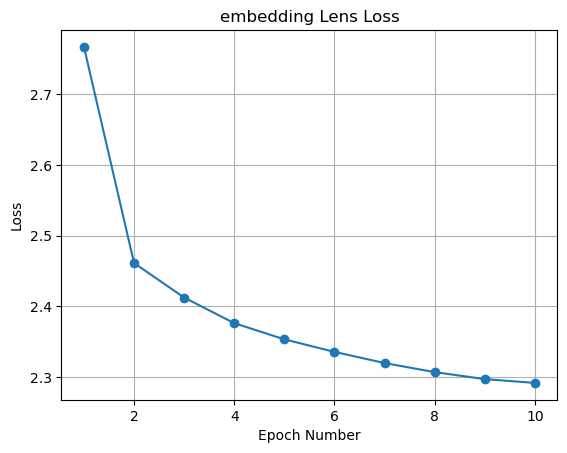

[2.7669233671443267,
 2.461417372209516,
 2.4126152815093076,
 2.3764096813488256,
 2.3535414388312903,
 2.3357954705551096,
 2.3200247835340697,
 2.307193232957446,
 2.2972984156018676,
 2.291921308088586]

In [18]:
# Training
embedding_lens.train_model(train_dataloader=embedding_train_loader,
                           criterion=kl_loss_teacher_student,
                           optimizer=embedding_optimizer,
                           num_epochs=num_epochs,
                           device=device,
                           proj_dir=proj_dir,
                           sub_model=embedding_model,     # should return (B,S,d_model)
                           final_model=model,             # teacher model: returns (B,S,V)
                           pad_token_id=pad_idx,
                           scheduler=embedding_scheduler)

In [19]:
# Evaluation
embedding_lens.evaluate_model(test_dataloader=embedding_test_loader,
                              criterion=kl_loss_teacher_student,
                              device=device,
                              sub_model=embedding_model,
                              final_model=model,
                              pad_token_id=pad_idx)

Eval embedding lens: 100%|██████████| 42696/42696 [04:36<00:00, 154.48it/s]


Eval embedding Lens - Avg loss: 2.294325, Accuracy vs teacher (last pos): 0.1359


{'avg_val_loss': 2.294324900324657, 'accuracy': 0.1358675285741053}

### Preparing the Attention Lens

In [17]:
torch.cuda.empty_cache()

# Hyperparameters
batch_size = 2
num_epochs = 10

# Attention model
attention_model = AttentionModel(model.embedding, model.pos_embedding, model.compression, model.attention, pad_idx).to(device)

# Dataset + DataLoader that returns batches of token ids
attention_train_ds = BooksDataset(val_set)
attention_test_ds  = BooksDataset(test_set)

attention_train_loader = DataLoader(attention_train_ds, batch_size=batch_size, shuffle=True,
                          collate_fn=partial(collate_fn, pad_token_id=pad_idx),
                          num_workers=2, pin_memory=True)

attention_test_loader = DataLoader(attention_test_ds, batch_size=batch_size, shuffle=False,
                         collate_fn=partial(collate_fn, pad_token_id=pad_idx),
                         num_workers=2, pin_memory=True)

# Instantiating the attention lens
attention_lens = TunedLens(d_model=d_model,
                           last_norm=model.mlp_norm,
                           unembedding_layer=model.classification_layer,
                           name='attention',
                           bias_only = False).to(device)

# Optimizer & scheduler
attention_optimizer = optim.Adam(attention_lens.parameters(), lr=1e-3)

# OneCycleLR (per-batch)
attention_scheduler = OneCycleLR(attention_optimizer,
                       max_lr=1e-2,
                       steps_per_epoch=len(attention_train_loader),
                       epochs=num_epochs,
                       pct_start=0.3)

Starting TunedLens training loop...


Epoch 1/10: 100%|██████████| 21348/21348 [04:31<00:00, 78.60it/s]


Epoch [1/10]  Avg Loss: 1.905361  LR: 0.00280007


Epoch 2/10: 100%|██████████| 21348/21348 [04:32<00:00, 78.45it/s]


Epoch [2/10]  Avg Loss: 1.422403  LR: 0.00760014


Epoch 3/10: 100%|██████████| 21348/21348 [04:31<00:00, 78.75it/s]


Epoch [3/10]  Avg Loss: 1.377934  LR: 0.01


Epoch 4/10: 100%|██████████| 21348/21348 [04:29<00:00, 79.16it/s]


Epoch [4/10]  Avg Loss: 1.349659  LR: 0.0095048


Epoch 5/10: 100%|██████████| 21348/21348 [04:30<00:00, 78.90it/s]


Epoch [5/10]  Avg Loss: 1.332354  LR: 0.00811737


Epoch 6/10: 100%|██████████| 21348/21348 [04:30<00:00, 78.96it/s]


Epoch [6/10]  Avg Loss: 1.320174  LR: 0.00611252


Epoch 7/10: 100%|██████████| 21348/21348 [04:28<00:00, 79.38it/s]


Epoch [7/10]  Avg Loss: 1.310570  LR: 0.00388732


Epoch 8/10: 100%|██████████| 21348/21348 [04:27<00:00, 79.69it/s]


Epoch [8/10]  Avg Loss: 1.301653  LR: 0.0018825


Epoch 9/10: 100%|██████████| 21348/21348 [04:27<00:00, 79.77it/s]


Epoch [9/10]  Avg Loss: 1.293878  LR: 0.000495148


Epoch 10/10: 100%|██████████| 21348/21348 [04:29<00:00, 79.32it/s]


Epoch [10/10]  Avg Loss: 1.291215  LR: 4.00011e-08
Checkpoint for Epoch 10 saved to QLens/attention_lens_checkpoint.pth


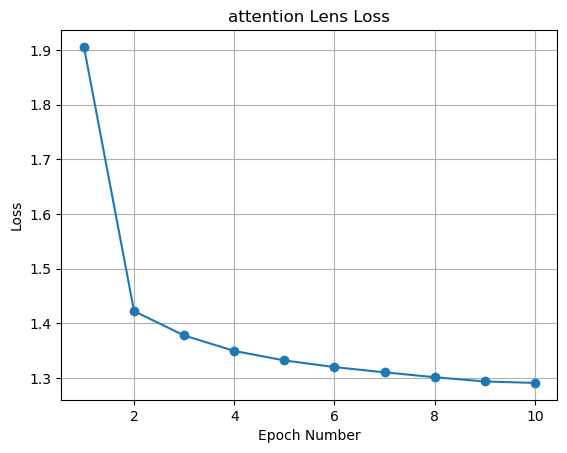

[1.9053606942131298,
 1.4224030791104945,
 1.3779335366706846,
 1.3496591117563197,
 1.3323541208389704,
 1.3201737061983327,
 1.310569951149862,
 1.3016533660312393,
 1.293877982391899,
 1.291215131459599]

In [18]:
# Training
attention_lens.train_model(train_dataloader=attention_train_loader,
                           criterion=kl_loss_teacher_student,
                           optimizer=attention_optimizer,
                           num_epochs=num_epochs,
                           device=device,
                           proj_dir=proj_dir,
                           sub_model=attention_model,
                           final_model=model,
                           pad_token_id=pad_idx,
                           scheduler=attention_scheduler)

In [19]:
# Evaluation
attention_lens.evaluate_model(test_dataloader=attention_test_loader,
                              criterion=kl_loss_teacher_student,
                              device=device,
                              sub_model=attention_model,
                              final_model=model,
                              pad_token_id=pad_idx)

Eval attention lens: 100%|██████████| 21348/21348 [03:55<00:00, 90.72it/s] 


Eval attention Lens - Avg loss: 1.292284, Accuracy vs teacher (last pos): 0.2339


{'avg_val_loss': 1.2922836955296808, 'accuracy': 0.2338626569233652}